In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import recall_score,precision_score, f1_score, roc_auc_score, confusion_matrix ,make_scorer
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False  # MINUS SIGN 사용 비활성화
mpl.rcParams['font.family'] = 'NanumGothic'  # 또는 다른 폰트


In [26]:
df = pd.read_csv('../파생변수데이터셋/외감_파생_ir.csv')
columns = ['이윤분배율', 'log총자산', '매출액순이익률', '비유동자산증가율', '부채비율', 
        '차입금의존도', '총자본순이익률', '자기자본구성비율', '비유동자산회전률', '매출액증가율', '부가가치율']

In [27]:
df[df['y']==1]['거래소코드'].nunique()

18546

In [28]:
# 성능확인 코드
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, fbeta_score
import numpy as np

import warnings

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    pr_score = average_precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    f2 = fbeta_score(y_test, pred, beta=2)
    # G-mean 계산
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    gmean = np.sqrt(tpr * tnr)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f},F1 스코어:{3:.4f}, f2 :{4:.4f}'.format(accuracy, precision, recall, f1, f2))
    print('ROC 스코어: {0:.4f}, PR 스코어 : {1:.4f}, G-mean : {2:.4f}'.format(roc_score, pr_score, gmean))

# 임계값에 따른 오차행렬및 스코어 -------->#임계값 최적 : 재현율기준(0.1)/f1기준(0.3)
from sklearn.preprocessing import Binarizer
thresholds = [0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        # ROC 커브 계산
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba_c1)
        roc_auc = auc(fpr, tpr)
        print("임곗값:", custom_threshold)
        print("ROC_AUC:", roc_auc)
        get_clf_eval(y_test, custom_predict)
        print("---------------------------------------------------------")

from sklearn.metrics import roc_curve, auc
def roc(model,name) :
    # 테스트 데이터에 대한 예측 확률 계산
    pred = model.predict_proba(X_test)[:, 1]

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC 커브에 AUC 면적에 색을 입히는 코드 수정
    plt.figure(figsize=(10, 6))

    # ROC 커브 시각화 및 AUC 면적 색칠
    plt.fill_between(fpr, tpr, color='palegoldenrod', alpha=0.4, label=f'Area under curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr, tpr, color='peru', lw=2)

    # 기본 설정
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}')
    plt.legend(loc="lower right")
    return plt.show()

In [29]:
# 클래스 레이블 y가 1인 경우에 대한 처리
for i in columns:
    # 무한대 값 제외하고 최대값, 최소값 계산
    max_value = df.loc[(df['y'] == 1) & (np.isfinite(df[i])), i].max()
    min_value = df.loc[(df['y'] == 1) & (np.isfinite(df[i])), i].min()

    # 무한대 값을 최대값 또는 최소값으로 대체
    df.loc[(df['y'] == 1) & (df[i] == np.inf), i] = max_value
    df.loc[(df['y'] == 1) & (df[i] == -np.inf), i] = min_value

# 클래스 레이블 y가 0인 경우에 대한 처리
for i in columns:
    # 무한대 값 제외하고 최대값, 최소값 계산
    max_value = df.loc[(df['y'] == 0) & (np.isfinite(df[i])), i].max()
    min_value = df.loc[(df['y'] == 0) & (np.isfinite(df[i])), i].min()

    # 무한대 값을 최대값 또는 최소값으로 대체
    df.loc[(df['y'] == 0) & (df[i] == np.inf), i] = max_value
    df.loc[(df['y'] == 0) & (df[i] == -np.inf), i] = min_value

In [30]:
train = df[df['회계년도'] <= '2020-11-01']
test = df[df['회계년도'] >= '2020-11-01']

In [31]:
len(train)

101635

In [32]:
len(train[train['y']==0]['y']), len(train[train['y']==1]['y'])

(88231, 13404)

In [33]:
len(test[test['y']==0]['y']), len(test[test['y']==1]['y'])

(45874, 6199)

In [34]:
from scipy.stats.mstats import winsorize


# 데이터프레임의 각 열에 대해 winsorize를 적용
for col in columns:
    # y == 1인 경우
    train.loc[train['y'] == 1, col] = winsorize(train.loc[train['y'] == 1, col], limits=[0.01, 0.01])
    test.loc[test['y'] == 1, col] = winsorize(test.loc[test['y'] == 1, col], limits=[0.01, 0.01])

    # y == 0인 경우
    train.loc[train['y'] == 0, col] = winsorize(train.loc[train['y'] == 0, col], limits=[0.01, 0.01])
    test.loc[test['y'] == 0, col] = winsorize(test.loc[test['y'] == 0, col], limits=[0.01, 0.01])

# 결과 확인
train[columns].describe()


,이윤분배율,log총자산,매출액순이익률,비유동자산증가율,부채비율,차입금의존도,총자본순이익률,자기자본구성비율,비유동자산회전률,매출액증가율,부가가치율
count,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000
mean,2.635099,7.471867,-11.060317,16.895618,366.768568,34.693735,2.398172,44.087379,8.076822,19.910724,16.078776
std,115.336406,0.429932,179.727287,103.003094,1634.431960,30.970550,12.026207,26.898089,33.987769,150.577782,91.225844
min,-1838.270000,5.993832,-4036.770000,-96.800000,0.000000,0.000000,-118.180000,0.000000,0.000000,-91.440000,-1932.130000
25%,0.570000,7.178010,0.050000,-4.770000,41.305000,7.040000,0.070000,23.440000,0.670000,-9.140000,7.740000
50%,18.370000,7.382056,2.470000,0.320000,119.820000,31.830000,2.450000,41.400000,1.780000,1.170000,15.270000
75%,39.200000,7.683425,7.370000,12.820000,269.585000,54.050000,6.720000,64.965000,4.290000,15.050000,27.810000
max,93.250000,8.997554,119.590000,2122.420000,33825.010000,292.300000,36.380000,98.210000,650.920000,3127.300000,175.200000


In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 스케일러 초기화
scaler = StandardScaler()
scale_columns = columns

# 훈련 데이터에 대해 스케일러 학습 및 변환
train.loc[:,scale_columns] = scaler.fit_transform(train[scale_columns])

# 테스트 데이터 변환 (훈련 데이터로부터 학습된 파라미터 사용)
test.loc[:,scale_columns] = scaler.transform(test[scale_columns])

In [36]:
# X_y 분류
y_train = train['y']
X_train = train[columns]

y_test = test['y']
X_test = test[columns]

In [57]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours

# smote = BorderlineSMOTE(k_neighbors=7, m_neighbors=7,sampling_strategy=0.25, random_state=17)
smote = ADASYN(n_neighbors=5,sampling_strategy=0.3, random_state=17)
# under = EditedNearestNeighbours(n_neighbors=5)
# SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# X_test, y_test = under.fit_resample(X_test,y_test)
# Checking the shape of the original and resampled data
original_shape = train.shape
resampled_shape = X_resampled.shape

original_shape, resampled_shape

((101635, 59), (112764, 11))

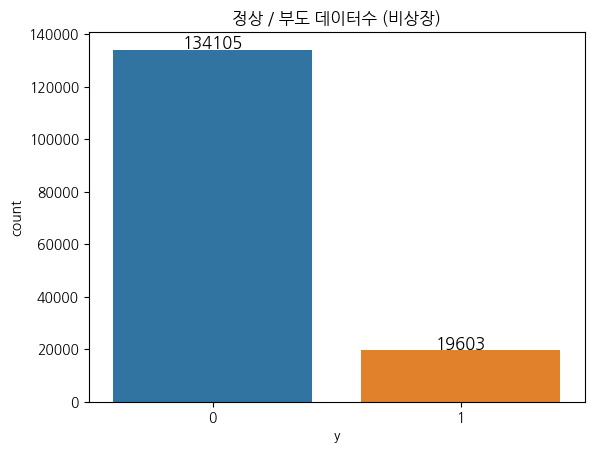

In [58]:
import seaborn as sns

ax = sns.countplot(x="y", data=df[['y']])
plt.title("정상 / 부도 데이터수 (비상장)")

# 각 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.show()

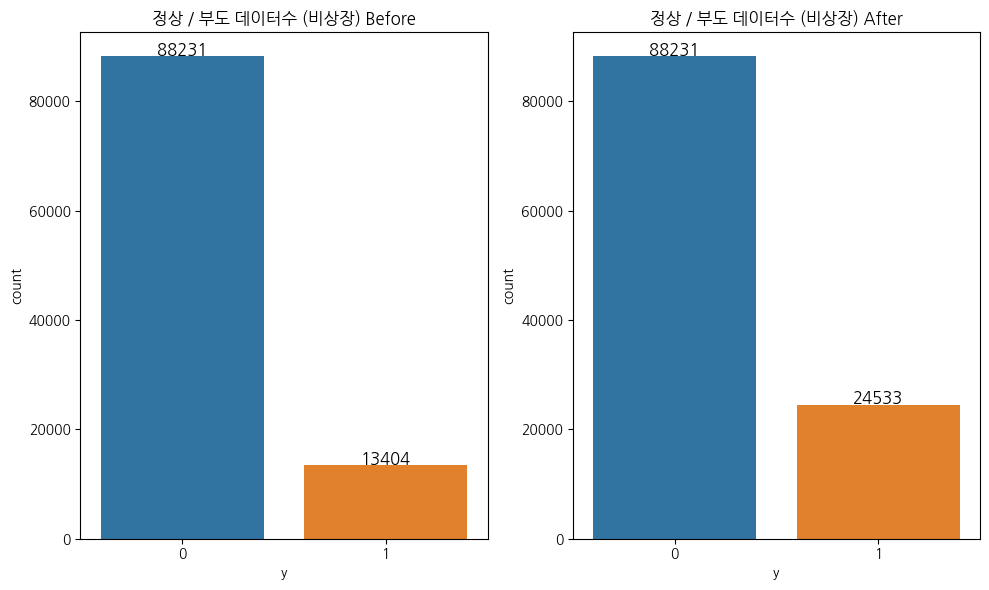

<Figure size 640x480 with 0 Axes>

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 두 데이터셋을 시각화합니다.
plt.figure(figsize=(10, 6))
# 첫 번째 데이터셋
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x="y", data=train[['y']], ax=ax1)
plt.title("정상 / 부도 데이터수 (비상장) Before")

# 각 막대 위에 숫자 표시
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
    
# 두 번째 데이터셋 (시리즈)
ax2 = plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, ax=ax2)
plt.title("정상 / 부도 데이터수 (비상장) After")

# 각 막대 위에 숫자 표시
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show() 
plt.tight_layout()
plt.show()

In [60]:
X_train

,이윤분배율,log총자산,매출액순이익률,비유동자산증가율,부채비율,차입금의존도,총자본순이익률,자기자본구성비율,비유동자산회전률,매출액증가율,부가가치율
0,0.270383,3.548689,0.068383,-0.124420,-0.144319,-0.731787,-0.087989,-0.028901,-0.108770,-0.039121,-0.136352
1,0.029522,3.548689,0.062541,0.009460,-0.150419,-0.704664,-0.182783,0.043595,-0.129071,-0.174733,-0.144025
2,0.092902,3.548689,0.064099,-0.174128,-0.162858,-0.836726,-0.161995,0.214240,-0.149961,-0.218630,-0.138106
3,-0.022847,3.548689,-0.015689,-0.242961,-0.135674,-0.688520,-1.158157,-0.121845,-0.160259,-0.237956,-0.318429
4,0.177611,3.548689,0.066992,0.191688,-0.132394,-0.469278,-0.120419,-0.154189,-0.159082,-0.033011,-0.129885
...,...,...,...,...,...,...,...,...,...,...,...
141554,0.541071,-1.672526,0.115678,1.979702,-0.122305,-0.038222,2.825662,-0.246018,0.333450,2.636652,-0.012264
142391,-0.022847,-0.466359,0.022536,2.456194,0.611905,1.458692,-1.052554,-1.385510,-0.114066,-0.174666,-0.209906
146707,-0.022847,-1.085619,-0.367056,0.011207,-0.224402,1.933016,-1.996331,-1.639061,-0.225871,-0.593123,-0.889542
146713,-0.265877,-2.287038,-0.047459,-1.103813,-0.224402,1.205547,-1.065027,-1.639061,-0.219987,-0.126319,0.589761


In [61]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=17
                        , penalty='l2'
                        , dual=False
                        , tol=0.0001
                        , C=0.7
                        , solver='liblinear'
                        , max_iter=100
                        , multi_class='auto'
                        )
lr.fit(X_resampled, y_resampled)
lr_pred = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)

get_clf_eval(y_test, lr_pred)
get_eval_by_threshold(y_test , lr_pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[43090  2784]
 [ 3466  2733]]
정확도: 0.8800, 정밀도 : 0.4954, 재현율:0.4409,F1 스코어:0.4665, f2 :0.4508
ROC 스코어: 0.6901, PR 스코어 : 0.2850, G-mean : 0.6435
임곗값: 0.1
ROC_AUC: 0.8404430701676573
오차행렬
[[23825 22049]
 [  603  5596]]
정확도: 0.5650, 정밀도 : 0.2024, 재현율:0.9027,F1 스코어:0.3307, f2 :0.5336
ROC 스코어: 0.7110, PR 스코어 : 0.1943, G-mean : 0.6847
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.8404430701676573
오차행렬
[[29150 16724]
 [  940  5259]]
정확도: 0.6608, 정밀도 : 0.2392, 재현율:0.8484,F1 스코어:0.3732, f2 :0.5621
ROC 스코어: 0.7419, PR 스코어 : 0.2210, G-mean : 0.7342
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.8404430701676573
오차행렬
[[33057 12817]
 [ 1286  4913]]
정확도: 0.7292, 정밀도 : 0.2771, 재현율:0.7925,F1 스코어:0.4106, f2 :0.5776
ROC 스코어: 0.7566, PR 스코어 : 0.2443, G-mean : 0.7557
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.8404430701676573
오차행렬
[[35907  9967]
 [ 1646  4553]]
정확도: 0.7770, 정밀도 : 0.3136, 재현율:0.7345,F1

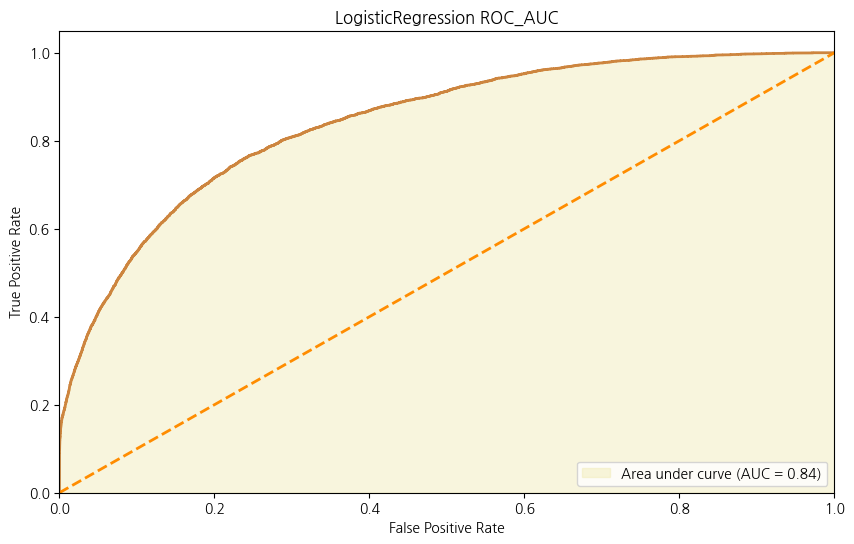

In [62]:
roc(lr, 'LogisticRegression ROC_AUC')

In [63]:
# 모델의 계수 추출
coefficients = lr.coef_[0]

# 피쳐 이름과 계수를 DataFrame으로 생성
feature_importance = pd.DataFrame({'Feature': X_resampled.columns, 'Coefficient': coefficients})

# 계수의 절대값을 기준으로 피쳐 중요도 정렬
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=True)

# 결과 출력
print(feature_importance)

     Feature  Coefficient  Absolute_Coefficient
6    총자본순이익률     0.003483              0.003483
8   비유동자산회전률     0.078648              0.078648
0      이윤분배율    -0.121351              0.121351
9     매출액증가율     0.180051              0.180051
5     차입금의존도     0.184352              0.184352
4       부채비율     0.189952              0.189952
3   비유동자산증가율     0.232844              0.232844
2    매출액순이익률    -0.347273              0.347273
7   자기자본구성비율    -0.764950              0.764950
10     부가가치율    -0.872100              0.872100
1     log총자산    -1.132803              1.132803


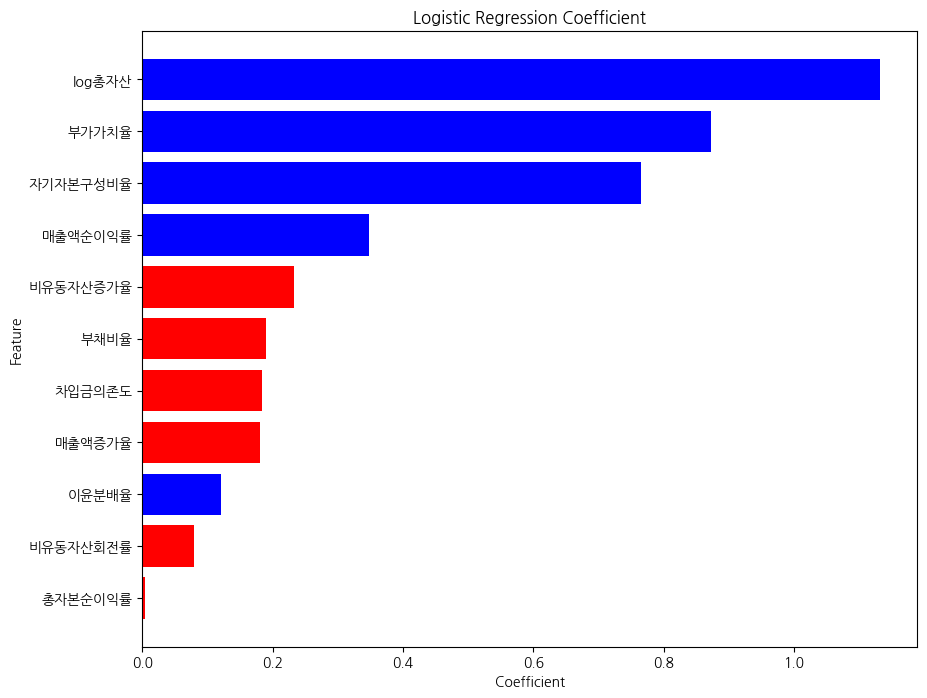

In [64]:
# 상위 10개 중요 피쳐만 선택
top_features = feature_importance.tail(15)

# Calculate absolute values of coefficients
top_features['Absolute_Coefficient'] = top_features['Coefficient'].abs()

# Sorting features based on absolute values of coefficients
top_features = top_features.sort_values(by='Absolute_Coefficient', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(top_features['Feature'], top_features['Absolute_Coefficient'], 
                color=np.where(top_features['Coefficient'] < 0, 'blue', 'red'))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficient')

# Show plot
plt.show()

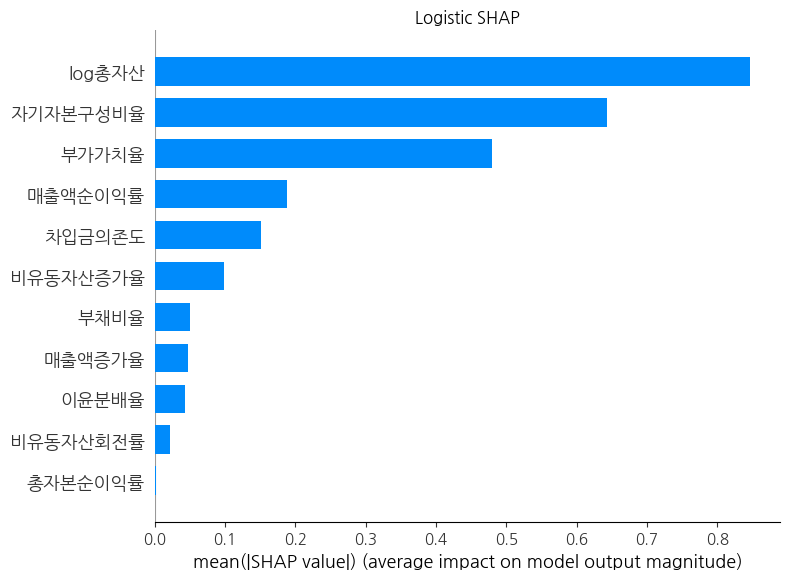

In [65]:
shap.initjs()
lr_explainer = shap.LinearExplainer(lr, X_train)
lr_shap_values = lr_explainer.shap_values(X_train)
plt.title('Logistic SHAP')
shap.summary_plot(lr_shap_values, X_train, plot_type='bar')

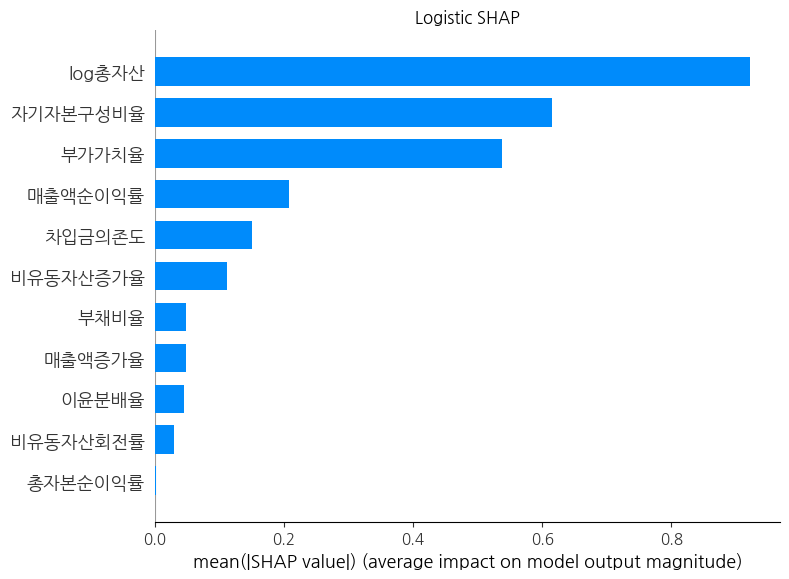

In [66]:
shap.initjs()
lr_explainer = shap.Explainer(lr, X_train)
lr_shap_values = lr_explainer.shap_values(X_test)
plt.title('Logistic SHAP')
shap.summary_plot(lr_shap_values, X_test, plot_type='bar')

In [67]:
from lime.lime_tabular import LimeTabularExplainer

import pandas as pd

# Feature names를 사용하여 DataFrame 생성
feature_names = columns

# 모델의 정확도 평가
lr_y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, lr_y_pred)

# LIME 설명자 초기화
explainer = LimeTabularExplainer(
    X_train.values, 
    feature_names=feature_names,
    class_names=[0, 1],
    discretize_continuous=True
)

# 테스트 데이터셋의 한 샘플에 대한 설명 생성
idx = 20  # 예시 샘플 인덱스
exp = explainer.explain_instance(X_test.iloc[idx].values, lr.predict_proba, num_features=15)

# 설명 결과 출력
exp_list = exp.as_list()
exp_list, accuracy


X does not have valid feature names, but LogisticRegression was fitted with feature names


([('log총자산 > 0.49', -0.24917403633696877),
  ('자기자본구성비율 > 0.78', -0.1810054313841499),
  ('부가가치율 > 0.13', -0.13711147013224753),
  ('비유동자산증가율 > -0.04', 0.05851675002239055),
  ('매출액증가율 <= -0.19', -0.039592005118942966),
  ('매출액순이익률 > 0.10', -0.03821107686721196),
  ('차입금의존도 <= -0.89', -0.03771649288678222),
  ('부채비율 <= -0.20', -0.017749781010346605),
  ('이윤분배율 > 0.32', -0.011536181894360028),
  ('총자본순이익률 > 0.36', 0.009564196153493198),
  ('-0.22 < 비유동자산회전률 <= -0.19', 0.0008304623774136568)],
 0.8799761872755555)

In [68]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=17
                            , min_samples_split=2
                            , min_samples_leaf=5
                            , max_depth=5
                            )

dt.fit(X_resampled, y_resampled)
dt_pred = dt.predict(X_test)
dt_pred_proba = dt.predict_proba(X_test)

get_clf_eval(y_test, dt_pred)
get_eval_by_threshold(y_test , dt_pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[42247  3627]
 [ 2936  3263]]
정확도: 0.8740, 정밀도 : 0.4736, 재현율:0.5264,F1 스코어:0.4986, f2 :0.5149
ROC 스코어: 0.7237, PR 스코어 : 0.3057, G-mean : 0.6962
임곗값: 0.1
ROC_AUC: 0.8453098256618143
오차행렬
[[25902 19972]
 [  448  5751]]
정확도: 0.6079, 정밀도 : 0.2236, 재현율:0.9277,F1 스코어:0.3603, f2 :0.5692
ROC 스코어: 0.7462, PR 스코어 : 0.2160, G-mean : 0.7238
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.8453098256618143
오차행렬
[[30860 15014]
 [  825  5374]]
정확도: 0.6958, 정밀도 : 0.2636, 재현율:0.8669,F1 스코어:0.4043, f2 :0.5947
ROC 스코어: 0.7698, PR 스코어 : 0.2443, G-mean : 0.7637
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.8453098256618143
오차행렬
[[31745 14129]
 [  925  5274]]
정확도: 0.7109, 정밀도 : 0.2718, 재현율:0.8508,F1 스코어:0.4120, f2 :0.5966
ROC 스코어: 0.7714, PR 스코어 : 0.2490, G-mean : 0.7673
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.8453098256618143
오차행렬
[[33903 11971]
 [ 1175  5024]]
정확도: 0.7475, 정밀도 : 0.2956, 재현율:0.8105,F1

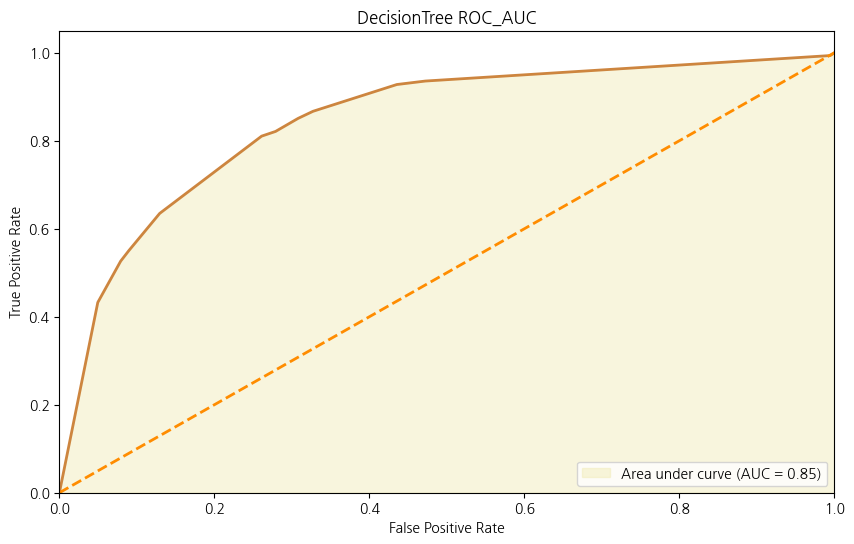

In [69]:
roc(dt, 'DecisionTree ROC_AUC')

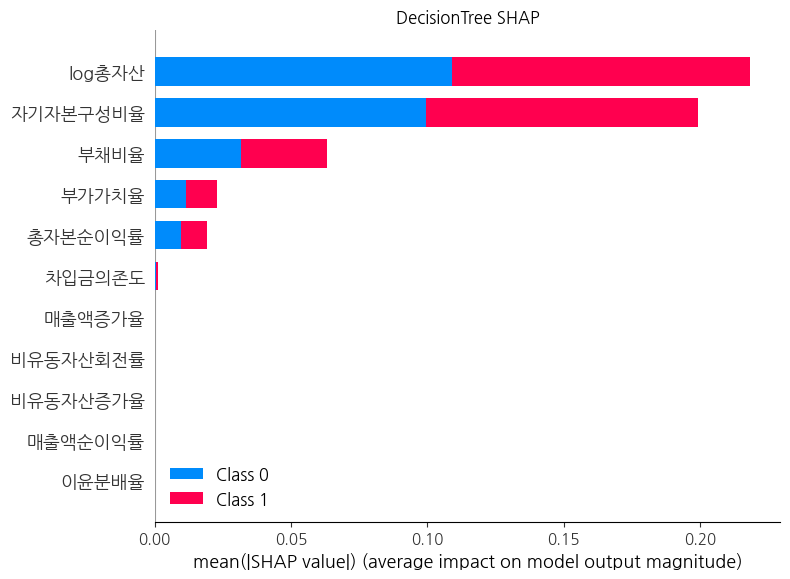

In [70]:
shap.initjs()
dt_explainer = shap.TreeExplainer(dt)
dt_shap_values = dt_explainer.shap_values(X_train)
plt.title('DecisionTree SHAP')
shap.summary_plot(dt_shap_values, X_train, plot_type='bar')

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=17, 
                            n_estimators=100, 
                            max_depth=4, 
                            min_samples_split=2,
                            min_samples_leaf=1)
rf.fit(X_resampled, y_resampled)
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)

get_clf_eval(y_test, rf_pred)
get_eval_by_threshold(y_test , rf_pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[44836  1038]
 [ 3622  2577]]
정확도: 0.9105, 정밀도 : 0.7129, 재현율:0.4157,F1 스코어:0.5252, f2 :0.4535
ROC 스코어: 0.6965, PR 스코어 : 0.3659, G-mean : 0.6374
임곗값: 0.1
ROC_AUC: 0.8556242182492436
오차행렬
[[22499 23375]
 [  434  5765]]
정확도: 0.5428, 정밀도 : 0.1978, 재현율:0.9300,F1 스코어:0.3263, f2 :0.5344
ROC 스코어: 0.7102, PR 스코어 : 0.1923, G-mean : 0.6754
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.8556242182492436
오차행렬
[[26843 19031]
 [  620  5579]]
정확도: 0.6226, 정밀도 : 0.2267, 재현율:0.9000,F1 스코어:0.3622, f2 :0.5646
ROC 스코어: 0.7426, PR 스코어 : 0.2159, G-mean : 0.7257
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.8556242182492436
오차행렬
[[30741 15133]
 [  892  5307]]
정확도: 0.6923, 정밀도 : 0.2596, 재현율:0.8561,F1 스코어:0.3984, f2 :0.5866
ROC 스코어: 0.7631, PR 스코어 : 0.2394, G-mean : 0.7574
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.8556242182492436
오차행렬
[[37163  8711]
 [ 1909  4290]]
정확도: 0.7961, 정밀도 : 0.3300, 재현율:0.6920,F1

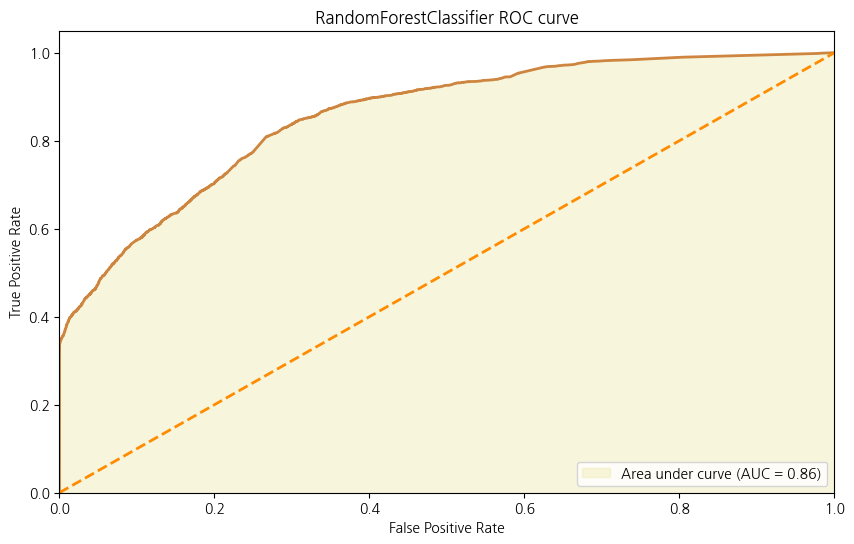

In [72]:
roc(rf, 'RandomForestClassifier ROC curve')

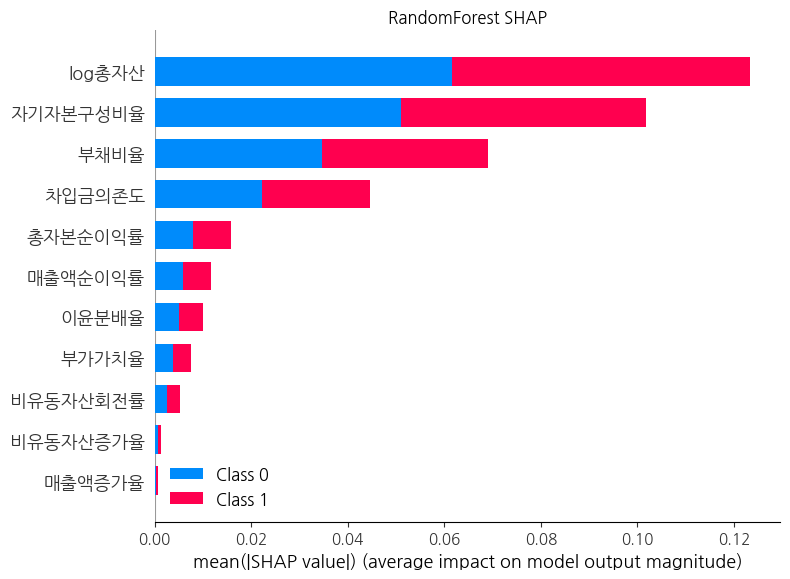

In [73]:
shap.initjs()
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_train)
plt.title('RandomForest SHAP')
shap.summary_plot(rf_shap_values, X_train, plot_type='bar')

In [79]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=17,
                    n_estimators=70,
                    max_depth=4,
                    learning_rate=0.15,
                    reg_lambda=3,
                    reg_alpha=0.1,
                    min_split_loss=1
                    )
xgb.fit(X_resampled, y_resampled)
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

get_clf_eval(y_test, xgb_pred)
get_eval_by_threshold(y_test , xgb_pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[41009  4865]
 [ 2660  3539]]
정확도: 0.8555, 정밀도 : 0.4211, 재현율:0.5709,F1 스코어:0.4847, f2 :0.5330
ROC 스코어: 0.7324, PR 스코어 : 0.2915, G-mean : 0.7144
임곗값: 0.1
ROC_AUC: 0.8769561821788899
오차행렬
[[28382 17492]
 [  415  5784]]
정확도: 0.6561, 정밀도 : 0.2485, 재현율:0.9331,F1 스코어:0.3925, f2 :0.6016
ROC 스코어: 0.7759, PR 스코어 : 0.2398, G-mean : 0.7598
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.8769561821788899
오차행렬
[[31751 14123]
 [  663  5536]]
정확도: 0.7161, 정밀도 : 0.2816, 재현율:0.8930,F1 스코어:0.4282, f2 :0.6227
ROC 스코어: 0.7926, PR 스코어 : 0.2642, G-mean : 0.7862
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.8769561821788899
오차행렬
[[34084 11790]
 [  897  5302]]
정확도: 0.7564, 정밀도 : 0.3102, 재현율:0.8553,F1 스코어:0.4553, f2 :0.6329
ROC 스코어: 0.7991, PR 스코어 : 0.2825, G-mean : 0.7972
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.8769561821788899
오차행렬
[[35835 10039]
 [ 1209  4990]]
정확도: 0.7840, 정밀도 : 0.3320, 재현율:0.8050,F1

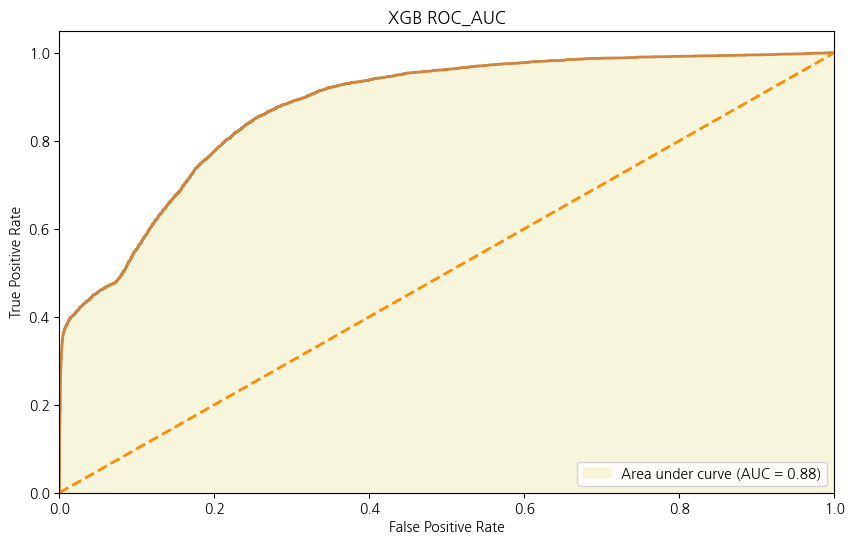

In [80]:
roc(xgb, 'XGB ROC_AUC')

[10:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


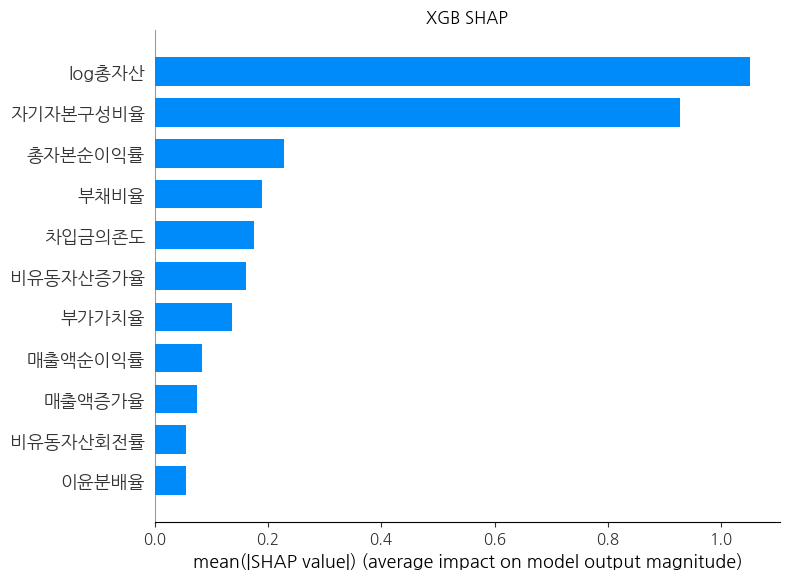

In [81]:
shap.initjs()
xgb_explainer = shap.TreeExplainer(xgb)
xgb_shap_values = xgb_explainer.shap_values(X_train)
plt.title('XGB SHAP')
shap.summary_plot(xgb_shap_values, X_train, plot_type='bar')

In [97]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=17,
                    n_estimators=80, #트리의 최대 개수 (n_estimators): 100
                    learning_rate=0.07,  #학습률 (learning_rate): 0.1
                    num_leaves=31,  #리프 노드의 최대 개수 (num_leaves): 31
                    max_depth=3,
                    bagging_fraction=0.5, 
                    feature_fraction=0.5, 
                    lambda_l1=0.2, 
                    lambda_l2=0.2,#트리의 최대 깊이 (max_depth): -1 (제한 없음)
                    verbose_eval = -1
                    )
lgb.fit(X_resampled, y_resampled)
lgb_pred = lgb.predict(X_test)
lgb_pred_proba = lgb.predict_proba(X_test)

get_clf_eval(y_test, lgb_pred)
get_eval_by_threshold(y_test , lgb_pred_proba[:,1].reshape(-1,1), thresholds)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


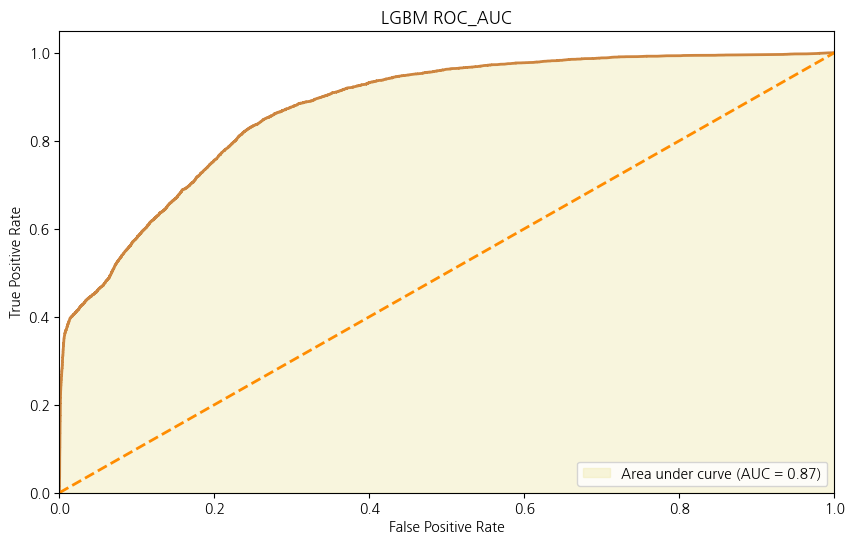

In [98]:
roc(lgb, 'LGBM ROC_AUC')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


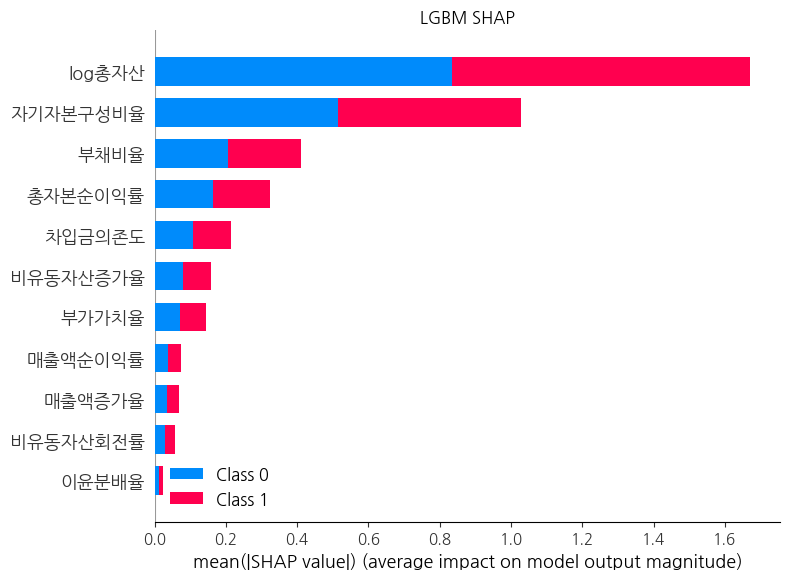

In [99]:
shap.initjs()
lgb_explainer = shap.TreeExplainer(lgb)
lgb_shap_values = lgb_explainer.shap_values(X_train)
plt.title('LGBM SHAP')
shap.summary_plot(lgb_shap_values, X_train, plot_type='bar')

In [100]:
from sklearn.svm import SVC
svc = SVC(random_state=17,probability=True, kernel='rbf')
svc.fit(X_resampled, y_resampled)
svc_pred = svc.predict(X_test)
svc_pred_proba = svc.predict_proba(X_test)

get_clf_eval(y_test, svc_pred)
get_eval_by_threshold(y_test , svc_pred_proba[:,1].reshape(-1,1), thresholds)

오차행렬
[[43348  2526]
 [ 3022  3177]]
정확도: 0.8935, 정밀도 : 0.5571, 재현율:0.5125,F1 스코어:0.5339, f2 :0.5208
ROC 스코어: 0.7287, PR 스코어 : 0.3435, G-mean : 0.6959
임곗값: 0.1
ROC_AUC: 0.851845801241993
오차행렬
[[16340 29534]
 [  331  5868]]
정확도: 0.4265, 정밀도 : 0.1658, 재현율:0.9466,F1 스코어:0.2821, f2 :0.4874
ROC 스코어: 0.6514, PR 스코어 : 0.1633, G-mean : 0.5807
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.851845801241993
오차행렬
[[36877  8997]
 [ 1625  4574]]
정확도: 0.7960, 정밀도 : 0.3370, 재현율:0.7379,F1 스코어:0.4627, f2 :0.5961
ROC 스코어: 0.7709, PR 스코어 : 0.2799, G-mean : 0.7702
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.851845801241993
오차행렬
[[38841  7033]
 [ 2041  4158]]
정확도: 0.8257, 정밀도 : 0.3715, 재현율:0.6708,F1 스코어:0.4782, f2 :0.5777
ROC 스코어: 0.7587, PR 스코어 : 0.2884, G-mean : 0.7536
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.851845801241993
오차행렬
[[39847  6027]
 [ 2275  3924]]
정확도: 0.8406, 정밀도 : 0.3943, 재현율:0.6330,F1 스코어

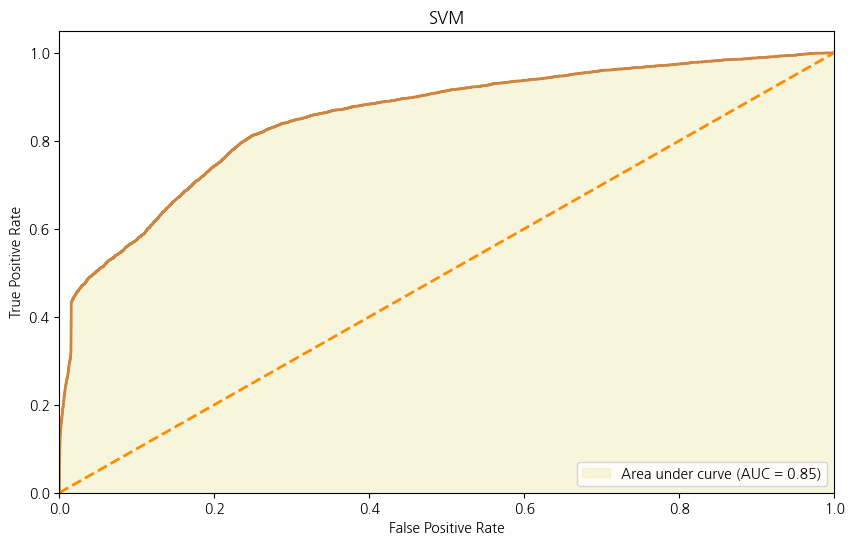

In [101]:
roc(svc, 'SVM')

In [102]:
shap.initjs()
svc_explainer = shap.KernelExplainer(svc.predict_proba, X_train)
svc_shap_values = svc_explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(svc_explainer.expected_value[0], svc_shap_values[0], X_test.iloc[0, :])


Using 101635 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


MemoryError: Unable to allocate 3.10 GiB for an array with shape (207945210, 2) and data type float64

In [159]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score

# TabNet 모델 초기화
tabnet = TabNetClassifier()

# 모델 학습
tabnet.fit(
        X_train=X_resampled.values,  # DataFrame을 NumPy 배열로 변환
        y_train=y_resampled.values,  # Series를 NumPy 배열로 변환
        eval_set=[(X_test.values, y_test.values)],  # 테스트 데이터도 변환
        eval_metric=['auc']
        )

# 테스트 데이터로 예측
tab_pred = tabnet.predict(X_test.values)
tab_pred_proba = tabnet.predict_proba(X_test.values)[:, 1]  # 예측도 NumPy 배열로 변환



get_clf_eval(y_test, tab_pred)
get_eval_by_threshold(y_test , tab_pred_proba.reshape(-1,1), thresholds)


Device used : cpu


epoch 0  | loss: 0.39716 | val_0_auc: 0.86759 |  0:00:13s
epoch 1  | loss: 0.342   | val_0_auc: 0.88583 |  0:00:26s
epoch 2  | loss: 0.33057 | val_0_auc: 0.88404 |  0:00:41s
epoch 3  | loss: 0.3278  | val_0_auc: 0.89184 |  0:00:53s
epoch 4  | loss: 0.32323 | val_0_auc: 0.89458 |  0:01:04s
epoch 5  | loss: 0.32205 | val_0_auc: 0.89131 |  0:01:16s
epoch 6  | loss: 0.31969 | val_0_auc: 0.89518 |  0:01:30s
epoch 7  | loss: 0.31881 | val_0_auc: 0.89828 |  0:01:44s
epoch 8  | loss: 0.31823 | val_0_auc: 0.89403 |  0:01:55s
epoch 9  | loss: 0.31664 | val_0_auc: 0.89576 |  0:02:06s
epoch 10 | loss: 0.31592 | val_0_auc: 0.89676 |  0:02:17s
epoch 11 | loss: 0.31504 | val_0_auc: 0.89581 |  0:02:28s
epoch 12 | loss: 0.31534 | val_0_auc: 0.89902 |  0:02:38s
epoch 13 | loss: 0.31452 | val_0_auc: 0.88625 |  0:02:49s
epoch 14 | loss: 0.31317 | val_0_auc: 0.89488 |  0:02:59s
epoch 15 | loss: 0.31277 | val_0_auc: 0.8907  |  0:03:09s
epoch 16 | loss: 0.31277 | val_0_auc: 0.89463 |  0:03:21s
epoch 17 | los

Best weights from best epoch are automatically used!


오차행렬
[[44453  1421]
 [ 3092  3107]]
정확도: 0.9133, 정밀도 : 0.6862, 재현율:0.5012,F1 스코어:0.5793, f2 :0.5298
ROC 스코어: 0.7351, PR 스코어 : 0.4033, G-mean : 0.6969
임곗값: 0.1
ROC_AUC: 0.8990172186785462
오차행렬
[[31037 14837]
 [  531  5668]]
정확도: 0.7049, 정밀도 : 0.2764, 재현율:0.9143,F1 스코어:0.4245, f2 :0.6256
ROC 스코어: 0.7955, PR 스코어 : 0.2629, G-mean : 0.7865
---------------------------------------------------------
임곗값: 0.15
ROC_AUC: 0.8990172186785462
오차행렬
[[34289 11585]
 [  831  5368]]
정확도: 0.7616, 정밀도 : 0.3166, 재현율:0.8659,F1 스코어:0.4637, f2 :0.6429
ROC 스코어: 0.8067, PR 스코어 : 0.2902, G-mean : 0.8045
---------------------------------------------------------
임곗값: 0.2
ROC_AUC: 0.8990172186785462
오차행렬
[[36901  8973]
 [ 1180  5019]]
정확도: 0.8050, 정밀도 : 0.3587, 재현율:0.8096,F1 스코어:0.4972, f2 :0.6470
ROC 스코어: 0.8070, PR 스코어 : 0.3131, G-mean : 0.8070
---------------------------------------------------------
임곗값: 0.25
ROC_AUC: 0.8990172186785462
오차행렬
[[38907  6967]
 [ 1526  4673]]
정확도: 0.8369, 정밀도 : 0.4015, 재현율:0.7538,F1

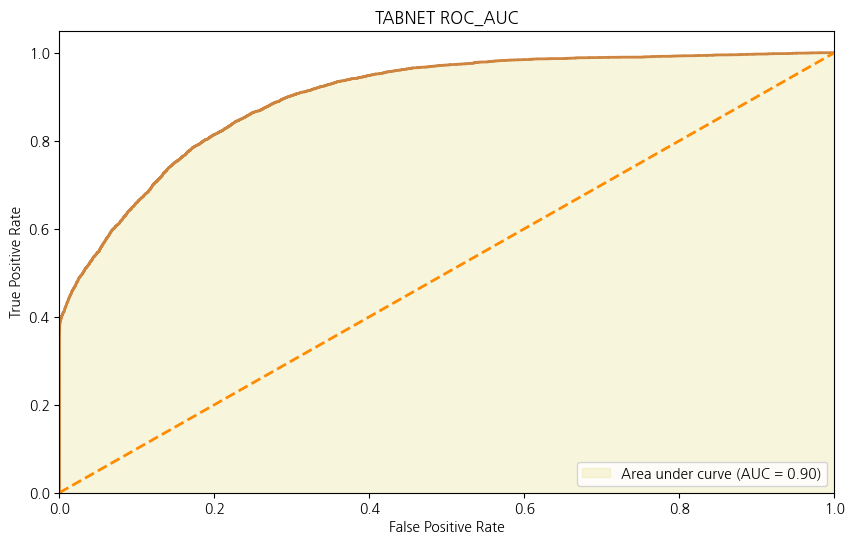

In [162]:
def tabnett(model,name,pred) :
    # 테스트 데이터에 대한 예측 확률 계산
    

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC 커브에 AUC 면적에 색을 입히는 코드 수정
    plt.figure(figsize=(10, 6))

    # ROC 커브 시각화 및 AUC 면적 색칠
    plt.fill_between(fpr, tpr, color='palegoldenrod', alpha=0.4, label=f'Area under curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr, tpr, color='peru', lw=2)

    # 기본 설정
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}')
    plt.legend(loc="lower right")
    return plt.show()

tabnett(tabnet, 'TABNET ROC_AUC', tab_pred_proba)

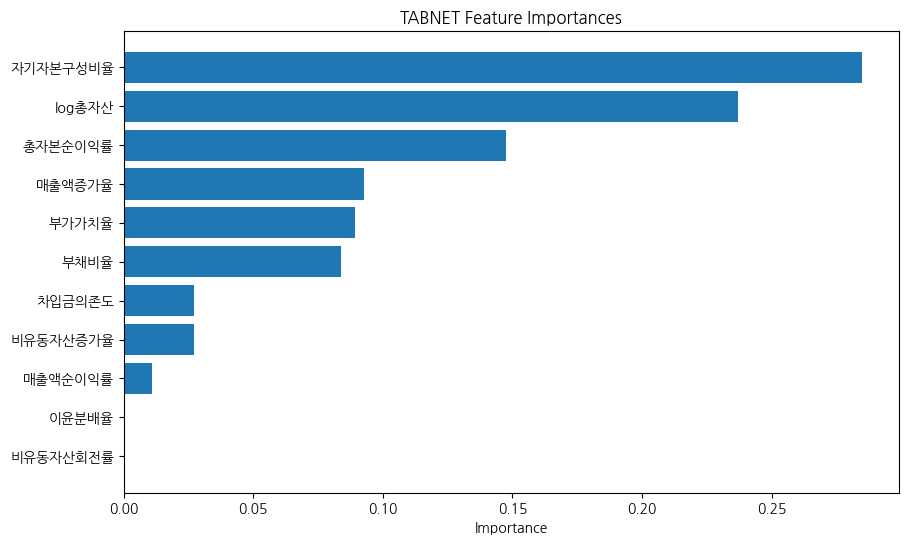

In [164]:
# 특성 중요도 추출
tabnet_feature_importances = tabnet.feature_importances_

# 특성명 가져오기 (X_resampled의 컬럼명 사용)
feature_names = X_resampled.columns

# 특성 중요도를 DataFrame으로 변환
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': tabnet_feature_importances})

# 중요도에 따라 내림차순 정렬
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.title('TABNET Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [166]:
shap.initjs()
tabnet_explainer = shap.DeepExplainer(tabnet, X_train)
tabnet_shap_values = tabnet_explainer.shap_values(X_test)
plt.title('TABNET SHAP')
shap.summary_plot(tabnet_shap_values, X_test, plot_type='bar')

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: <class 'pytorch_tabnet.tab_model.TabNetClassifier'> is not currently a supported model type!